In [1]:
import os
import tensorflow as tf

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.17.1
Eager mode:  True
GPU is available


In [2]:
import torch

print("Torch version:",torch.__version__)
print(torch.zeros(1).cuda())
print(torch.cuda.is_available())

Torch version: 2.5.1+cu121
tensor([0.], device='cuda:0')
True


# Read dataset

In [12]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.tokenize import word_tokenize

from utils.lemmatization import Lemmatization
from utils.preprocessing import Utilities

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Plot

In [4]:
movies = pd.read_csv('input/tmdb_5000_movies.csv')

print(len(movies))
# remove movies where overview is null or equals to ''
movies = movies.dropna(axis=0, subset=['overview'])

movies = movies[movies['overview'] != '']
print(len(movies))

4803
4800


## Plot observations

In [13]:
# Tokenize each paragraph in the 'overview' column and calculate the number of tokens
movies['tokens'] = movies['overview'].apply(lambda x: len(word_tokenize(x)))


# Calculate min, max, and average number of tokens
min_tokens = movies['tokens'].min()
max_tokens = movies['tokens'].max()
avg_tokens = movies['tokens'].mean()

print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print(f"Average number of tokens: {avg_tokens}")

Minimum number of tokens: 4
Maximum number of tokens: 198
Average number of tokens: 58.81746197124401


In [14]:
# remove movies where tokens are 0
movies = movies[movies['tokens'] != 0]

# Calculate min, max, and average number of tokens
min_tokens = movies['tokens'].min()
max_tokens = movies['tokens'].max()
avg_tokens = movies['tokens'].mean()

print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print(f"Average number of tokens: {avg_tokens}")

Minimum number of tokens: 4
Maximum number of tokens: 198
Average number of tokens: 58.81746197124401


In [15]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tokens,processed_plot
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,31,22nd century paraplegic marine dispatched moon...
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,38,captain barbossa long believed dead come back ...
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,46,cryptic message bond ’ past sends trail uncove...
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,74,following death district attorney harvey dent ...
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,63,john carter warweary former military captain s...


In [16]:
movies.iloc[0]['overview']

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

## Preprocessing

Remove stop words and punctuation

In [17]:
movies['processed_plot'] = movies['overview'].apply(Utilities.preprocess)

Print plots before and after preprocessing for the first 5 movies.

In [18]:
display(movies[['overview', 'processed_plot']].head())

,overview,processed_plot
0,"In the 22nd century, a paraplegic Marine is di...",22nd century paraplegic marine dispatched moon...
1,"Captain Barbossa, long believed to be dead, ha...",captain barbossa long believed dead come back ...
2,A cryptic message from Bond’s past sends him o...,cryptic message bond ’ past sends trail uncove...
3,Following the death of District Attorney Harve...,following death district attorney harvey dent ...
4,"John Carter is a war-weary, former military ca...",john carter warweary former military captain s...


## Lemmatization

In [19]:
movies['lem_processed_plot'] = movies['processed_plot'].apply(Lemmatization.lemmatize_sent)

In [20]:
display(movies[['processed_plot', 'lem_processed_plot']].head())

,processed_plot,lem_processed_plot
0,22nd century paraplegic marine dispatched moon...,22nd century paraplegic marine dispatch moon p...
1,captain barbossa long believed dead come back ...,captain barbossa long believe dead come back l...
2,cryptic message bond ’ past sends trail uncove...,cryptic message bond ’ past sends trail uncove...
3,following death district attorney harvey dent ...,follow death district attorney harvey dent bat...
4,john carter warweary former military captain s...,john carter warweary former military captain s...


## TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()

def calculate_similarity(df):
  overview_df = df['lem_processed_plot']
  movies_vector_1 = vectorizer.fit_transform(overview_df)

  return cosine_similarity(movies_vector_1)


similarity_matrix = calculate_similarity(movies)

In [22]:
def get_top_n_similar_indices(similarity_matrix, n=10):
    top_n_similar_indices = {}

    for i in range(similarity_matrix.shape[0]):
        similarity_scores = similarity_matrix[i]
        top_indices = np.argsort(similarity_scores)[::-1][1:n+1]
        top_n_similar_indices[i] = top_indices

    return top_n_similar_indices


movies['similar_movie_indices'] = get_top_n_similar_indices(similarity_matrix)

In [23]:
movies.iloc[0]

,0
budget,237000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/
id,19995
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
original_language,en
original_title,Avatar
overview,"In the 22nd century, a paraplegic Marine is di..."
popularity,150.437577
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289..."


# Categorize reviews

In [24]:
reviews = pd.read_csv('input/reviews.csv')

reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Dataset info

In [25]:
reviews.shape

(50000, 2)

Let's see if the positive and negative reviews are equally distributed within the dataset.

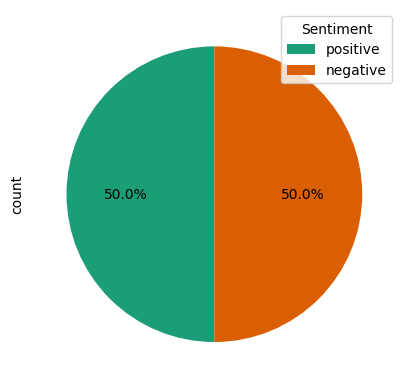

In [26]:
plt = reviews['sentiment'].value_counts().plot.pie(autopct='%1.1f%%',
                                                   colors=sns.palettes.mpl_palette('Dark2'),
                                                   labels=None,
                                                   legend=True,
                                                   startangle=90)
plt.legend(title="Sentiment", labels=reviews['sentiment'].value_counts().index)
# plt.bar_label(plt.containers[0])

As we can see they are equally distributed in our dataset.

## Preprocess

Since many reviews contain html tags, we are also going to remove them too

In [27]:
reviews['processed_review'] = reviews['review'].apply(Utilities.remove_html)

display(reviews[['review', 'processed_review']].head())

/content/utils/preprocessing.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  beautiful_soup = BeautifulSoup(text, 'html.parser')


,review,processed_review
0,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...","Petter Mattei's ""Love in the Time of Money"" is..."


In [28]:
# Use the preprocess method that was used in the movies plot

reviews['processed_review'] = reviews['processed_review'].apply(Utilities.preprocess)

Print first five reviews before and after preprocessing

In [29]:
display(reviews[['review', 'processed_review']].head())

,review,processed_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically s family little boy jake thinks s zo...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei s love time money visually stu...


## Lemmatization

In [30]:
reviews['lem_processed_review'] = reviews['processed_review'].apply(Lemmatization.lemmatize_sent)

display(reviews[['processed_review', 'lem_processed_review']].head(5))

,processed_review,lem_processed_review
0,one reviewers mentioned watching 1 oz episode ...,one reviewer mention watch 1 oz episode ll hoo...
1,wonderful little production filming technique ...,wonderful little production film technique una...
2,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...
3,basically s family little boy jake thinks s zo...,basically s family little boy jake think s zom...
4,petter mattei s love time money visually stu...,petter mattei s love time money visually stunn...


## Process sentiment column

Converts categorical labels of sentiment column into binary (1 for positive, 0 for negative)

Print the sentiment column unique values to confirm the encoding

In [31]:
print(reviews['sentiment'].unique())

['positive' 'negative']


In [32]:
#  Convert labels of positive/negative to binary values

reviews['sentiment_to_binary'] = reviews['sentiment'].map({ 'positive': 1, 'negative': 0 })
reviews.head()

,review,sentiment,processed_review,lem_processed_review,sentiment_to_binary
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...,one reviewer mention watch 1 oz episode ll hoo...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,wonderful little production film technique una...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...,1
3,Basically there's a family where a little boy ...,negative,basically s family little boy jake thinks s zo...,basically s family little boy jake think s zom...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love time money visually stu...,petter mattei s love time money visually stunn...,1


## Train models

### Split to train-test set

In [33]:
from sklearn.model_selection import train_test_split

x = reviews['lem_processed_review'].to_numpy()
y = reviews['sentiment_to_binary'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.30)

Use TfidfVectorizer to transform a collection of text documents into a matrix of TF-IDF features, which reflects the importance of a term in a document relative to the entire corpus. TF-IDF adjusts the term frequencies based on how common or rare a term is across the documents.

TfidfVectorizer is also a pre-processing technique used to convert text data into numerical form. TfidfVectorizer not only counts the frequency of each word but also assigns a weight to each word based on its frequency in the document and its frequency in the entire corpus. This means that it gives higher weights to words that are important or informative in the document and lower weights to common words that are not. This is achieved through a term frequency-inverse document frequency (TF-IDF) formula that balances the frequency of a word in a document with its frequency in the entire corpus.
(https://www.kaggle.com/code/zeeshanlatif/countvectorizer-vs-tfidfvectorizer)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import time

average_training_time = 0
metrics_dict = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1-score": [],
}

for index in range(5):
    random_forest = RandomForestClassifier(n_estimators=120, n_jobs=-1, criterion='gini', min_samples_split=3)
    start_time = time.time()
    random_forest.fit(x_train_tfidf, y_train)
    execution_time = time.time() - start_time
    average_training_time += execution_time

    y_pred_random_forest = random_forest.predict(x_test_tfidf)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_random_forest, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_random_forest)

    metrics_dict['accuracy'].append(accuracy)
    metrics_dict["precision"].append(precision)
    metrics_dict["recall"].append(recall)
    metrics_dict["f1-score"].append(f1)


average_metrics = {metric: np.mean(values) for metric, values in metrics_dict.items()}

print("\n===== Average Metrics of Random forest after 5 Runs =====")
print(f"Average Training Time: {average_training_time / 5:.3f} seconds")
print(f"Accuracy: {average_metrics['accuracy']:.4f}")
print(f"Precision: {average_metrics['precision']:.4f}")
print(f"Recall: {average_metrics['recall']:.4f}")
print(f"F1-Score: {average_metrics['f1-score']:.4f}")


===== Average Metrics of Random forest after 5 Runs =====
Average Training Time: 20.772 seconds
Accuracy: 0.8523
Precision: 0.8524
Recall: 0.8523
F1-Score: 0.8523


### Naive Bayes

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support
import time

average_training_time = 0
metrics_dict = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1-score": [],
}

for index in range(5):
    naive_bayes = MultinomialNB()
    start_time = time.time()
    naive_bayes.fit(x_train_tfidf, y_train)
    execution_time = time.time() - start_time
    average_training_time += execution_time

    y_predict_naive_bayes = naive_bayes.predict(x_test_tfidf)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_random_forest, average='weighted')
    accuracy = accuracy_score(y_test, y_predict_naive_bayes)

    metrics_dict['accuracy'].append(accuracy)
    metrics_dict["precision"].append(precision)
    metrics_dict["recall"].append(recall)
    metrics_dict["f1-score"].append(f1)


average_metrics = {metric: np.mean(values) for metric, values in metrics_dict.items()}

print("\n===== Average Metrics of Naive Bayes after 5 Runs =====")
print(f"Average Training Time: {average_training_time / 5:.3f} seconds")
print(f"Accuracy: {average_metrics['accuracy']:.4f}")
print(f"Precision: {average_metrics['precision']:.4f}")
print(f"Recall: {average_metrics['recall']:.4f}")
print(f"F1-Score: {average_metrics['f1-score']:.4f}")


===== Average Metrics of Naive Bayes after 5 Runs =====
Average Training Time: 0.029 seconds
Accuracy: 0.8620
Precision: 0.8511
Recall: 0.8511
F1-Score: 0.8511


### RNN model (Recurrent Neural Network)

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert text data to numerical format in oreder to feed them as input to RNN model
VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to ensure consistent input length
MAX_SEQUENCE_LENGTH = 100
x_train_padded = pad_sequences(x_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Creating the RNN model
model = tf.keras.Sequential([
    Embedding(input_dim=5000, output_dim=50),
    Bidirectional(
        LSTM(units=64),
    ),
    Dense(units=1, activation='sigmoid')
])

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(x_train_padded, y_train, validation_data=(x_test_padded, y_test), epochs=5, batch_size=64)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7390 - loss: 0.5028 - val_accuracy: 0.8695 - val_loss: 0.3180
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8963 - loss: 0.2619 - val_accuracy: 0.8757 - val_loss: 0.3066
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9124 - loss: 0.2203 - val_accuracy: 0.8748 - val_loss: 0.3046
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9299 - loss: 0.1852 - val_accuracy: 0.8698 - val_loss: 0.3218
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9433 - loss: 0.1525 - val_accuracy: 0.8653 - val_loss: 0.3443


In [42]:
loss, accuracy = model.evaluate(x_test_padded, y_test, batch_size=64)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8617 - loss: 0.3537
Test Loss: 0.34425413608551025
Test Accuracy: 0.8653333187103271


In [43]:
from sklearn.metrics import classification_report
# Get predicted probabilities
y_probs = model.predict(x_test_padded, batch_size=64)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_probs > 0.5).astype(int)

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7540
           1       0.85      0.89      0.87      7460

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



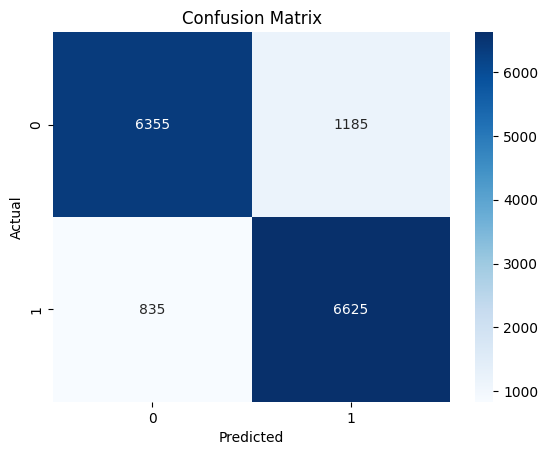

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

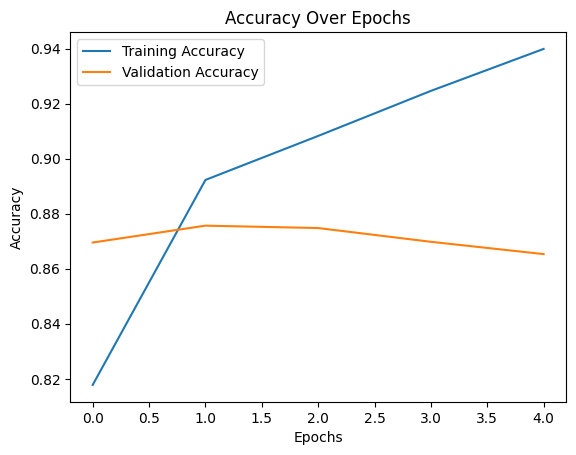

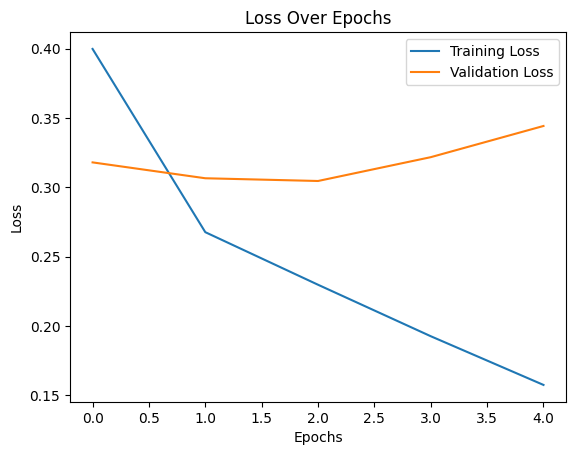

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

### BERT Transformer

In [47]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')
    accuracy = accuracy_score(y_test, y_predict_naive_bayes)

    # Combine metrics into a single dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "f1": f1,
        "recall": recall
    }

In [48]:
# Prepare the data for transformer model (padding, truncation and all the preprocessing are done in the DistillBert tokenizer)
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_inputs = tokenizer(x_train.tolist(), padding="max_length", max_length=128, truncation=True)

test_inputs = tokenizer(x_test.tolist(), padding="max_length", max_length=128, truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [49]:
import torch

# Convert our data into tensors (https://www.analyticsvidhya.com/blog/2022/02/sentiment-analysis-using-transformers/)
class ReviewDataset(torch.utils.data.Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = { key: torch.tensor(val[idx]) for key, val in self.encodings.items() }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [50]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
train_dataset = ReviewDataset(train_inputs, y_train.tolist())

test_dataset = ReviewDataset(test_inputs, y_test.tolist())

print(train_dataset.__getitem__(2))
print('\n')
print(test_dataset.__getitem__(2))

{'input_ids': tensor([  101,  3395,  2088,  2162,  2462,  2728,  4575, 15454,  5268, 11320,
         8091,  2080, 10887, 18801,  2386,  2162,  7794, 10760,  2275,  5787,
         3772,  2191,  2728,  4575,  4736,  2028,  2617,  4025,  3835, 28679,
         2166,  2034, 11320,  8091,  2080,  3046,  2393,  4025, 11587,  2498,
         4795,  2113, 23873,  3857,  5621,  5959,  2143,  2066, 11160,  2529,
         5783, 23873,  2158,  5214,  3496, 11472, 23257,  9266, 25218,  5754,
         6977, 13025,  2879,  2156,  2242,  3308,  2562,  3241,  2393,  4575,
         1055,  6180,  2735,  4150,  2066, 15333,  4801,  3363, 10536,  3207,
         2839,  2776,  5252, 11320,  8091,  2080,  5442,  5172,  3422,  2048,
        21688,  3364, 27743,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [52]:
# build the model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    report_to="none",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
)

distilbert_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-53-ec539ce7d0aa>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distilbert_trainer = Trainer(


In [55]:
distilbert_trainer.train()

Step,Training Loss
500,0.430500
1000,0.342700
1500,0.328100
2000,0.310900
2500,0.245400
3000,0.229000
3500,0.224500
4000,0.215900


TrainOutput(global_step=4376, training_loss=0.28442199225835435, metrics={'train_runtime': 224.4115, 'train_samples_per_second': 311.927, 'train_steps_per_second': 19.5, 'total_flos': 2318179476480000.0, 'train_loss': 0.28442199225835435, 'epoch': 2.0})

In [56]:
distilbert_trainer.evaluate()

{'eval_loss': 0.29627567529678345,
 'eval_accuracy': 0.862,
 'eval_precision': 0.8892529866358831,
 'eval_f1': 0.8891999192391098,
 'eval_recall': 0.8892,
 'eval_runtime': 15.7122,
 'eval_samples_per_second': 954.67,
 'eval_steps_per_second': 59.699,
 'epoch': 2.0}

### ROBERTA Transformer

In [57]:
from transformers import AutoTokenizer

# Prepare the data for transformer model (padding, truncation and all the preprocessing are done in the DistillBert tokenizer)
tokenizer_roberta = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

train_inputs_roberta = tokenizer_roberta(x_train.tolist(), padding="max_length", max_length=128, truncation=True)

test_inputs_roberta = tokenizer_roberta(x_test.tolist(), padding="max_length", max_length=128, truncation=True)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [58]:
# DataCollatorWithPadding is a class in Hugging Face Transformers that helps in preparing batches of data for training transformer models
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_roberta)

In [59]:
train_roberta_dataset = ReviewDataset(train_inputs_roberta, y_train.tolist())

test_roberta_dataset = ReviewDataset(test_inputs_roberta, y_test.tolist())

print(train_roberta_dataset.__getitem__(2))
print('\n')
print(test_roberta_dataset.__getitem__(2))

{'input_ids': tensor([    0, 40747,   232,   997, 42661,  4533,  6747,   910,  7010, 10363,
         9716,   784,   658,  1696,  6198, 14732,   397,   997, 18141,   627,
          278,  3000,  3501,   146,  4533,  6747,   910,  7010,  3050,    65,
         1151,  2045,  2579, 31643,   301,    78,   784,   658,  1696,   860,
          244,  2045,  9895,  1085,  2702,   216, 31803,  1119,  3127,  2254,
          822,   101,  5864,  1050,  7510, 31803,   313,  4453,  1310, 21388,
         1104,  3628,   263,   242,  2902,  3343, 36074,  8290,  2143,   192,
          402,  1593,   489,  2053,   244,   910,  7010,   579,  6718,  1004,
         3374,   101,  1236,  1951, 19221, 47961,  2048,  2140,  7859,   784,
          658,  1696, 11269,  1594,  2753, 22494,  1183,    80, 11415,  2701,
          361,   698,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

In [60]:
# build the model
from transformers import AutoModelForSequenceClassification

roberta_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", num_labels=2, ignore_mismatched_sizes=True)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

In [61]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    report_to="none", #remove this to save to wandb
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
)

roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_roberta_dataset,
    eval_dataset=test_roberta_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [62]:
roberta_trainer.train()

Step,Training Loss
500,0.371700
1000,0.322100
1500,0.309300
2000,0.290500
2500,0.236600
3000,0.216700
3500,0.206200
4000,0.205200


TrainOutput(global_step=4376, training_loss=0.2646727483494844, metrics={'train_runtime': 426.3384, 'train_samples_per_second': 164.189, 'train_steps_per_second': 10.264, 'total_flos': 4604443468800000.0, 'train_loss': 0.2646727483494844, 'epoch': 2.0})

In [63]:
roberta_trainer.evaluate()

{'eval_loss': 0.2643500566482544,
 'eval_accuracy': 0.862,
 'eval_precision': 0.9043644535702633,
 'eval_f1': 0.9042651417340969,
 'eval_recall': 0.9042666666666667,
 'eval_runtime': 28.1427,
 'eval_samples_per_second': 532.997,
 'eval_steps_per_second': 33.33,
 'epoch': 2.0}

# Final example

In [65]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/480.6 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/116.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/179.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/134.8 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/194.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2

In [68]:
from utils.recommendation import Recommendation
import random
from datasets import Dataset

value_for_positive = 'positive'
# value_for_positive = 1

def recommend_movies_based_on(movie_index):
    movie = movies.iloc[movie_index]
    print('Movie title: ' + movie['title'])

    print('\nSimilar movies based on plot:')
    plot_based_similar = []

    movies_with_reviews_perc=[]
    for i in movie['similar_movie_indices']:
        plot_based_similar.append(movies.iloc[i]['title'])
        print(movies.iloc[i]['title'])

        movie_reviews = Recommendation.get_reviews_for_movie(movies, movies.iloc[i])
        df = pd.DataFrame(movie_reviews, columns=['review'])
        if df['review'].size != 0:
            df['processed_review'] = df['review'].apply(Utilities.remove_html)
            df['processed_review'] = df['processed_review'].apply(Utilities.preprocess)
            df['lem_processed_review'] = df['processed_review'].apply(Lemmatization.lemmatize_sent)

            tokenized_input = tokenizer_roberta(df['lem_processed_review'].to_numpy().tolist(), padding="max_length", max_length=128, truncation=True)

            # review_pred = random_forest.predict(vectorizer.transform(df['processed_review'].to_numpy()))
            review_pred = roberta_trainer.predict(Dataset.from_dict(tokenized_input))

            # find number of positive reviews (first column)
            # count_of_ones = np.count_nonzero(review_pred[:, 0] == value_for_positive)
            count_of_ones = np.sum(review_pred == 'positive')
            # This one has 0 for all movies need to check why?
            movies_with_reviews_perc.append(tuple([movies.iloc[i]['title'], count_of_ones/df['processed_review'].size]))
        else:
            movies_with_reviews_perc.append(tuple([movies.iloc[i]['title'], 0]))

    print('Movies positive reviwes percentage = ', movies_with_reviews_perc, '\n')
    # Sort the list of movies by the second value (review percentage) in descending order
    sorted_movies = sorted(movies_with_reviews_perc, key=lambda x: x[1], reverse=True)

    print('\nSimilar movies based on reviews:')

    top_five_pairs = sorted_movies[:5]

    print([movie[0] for movie in top_five_pairs])
    return [movie[0] for movie in top_five_pairs], plot_based_similar


In [70]:
recommended, plot = recommend_movies_based_on(random.randint(0, len(movies.axes[0])-1))

Movie title: Equilibrium

Similar movies based on plot:
Mad Max
The Running Man


Inside Out
Ishtar
Serenity


The Last Castle


Brooklyn's Finest
Layer Cake
A Scanner Darkly


Sleeper
Movies positive reviwes percentage =  [('Mad Max', 0), ('The Running Man', 0.0), ('Inside Out', 0), ('Ishtar', 0), ('Serenity', 0.0), ('The Last Castle', 0.0), ("Brooklyn's Finest", 0), ('Layer Cake', 0), ('A Scanner Darkly', 0.0), ('Sleeper', 0)] 


Similar movies based on reviews:
['Mad Max', 'The Running Man', 'Inside Out', 'Ishtar', 'Serenity']
